In [1]:
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
from typing import Iterable
from dataclasses import dataclass

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class LeNet5(nn.Module):
    """LeNet5 MNIST handwritten digit classification model"""
    def __init__(self):
        super().__init__()

        # feature extractor
        self._body = nn.Sequential(
            # input = (32, 32), output = (28, 28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # input = (14, 14), output = (10, 10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # output = (5, 5)
        )
        
        # fully-connected layers
        self._head = nn.Sequential(
            # in_features = total number of weight in last conv layer = 16 * 5 * 5
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            # out_features = number of classes = 10 (MNIST data 0-9)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

In [3]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [4]:
def get_data(batch_size, data_root='data', num_workers=1):
    """Loads the data"""
    train_test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, )) # mean and variance
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            root=data_root, 
            train=True, 
            download=True, 
            transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            root=data_root, 
            train=False, 
            download=True, 
            transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    return train_loader, test_loader

In [5]:
@dataclass
class SystemConfiguration:
    "Sets the system config"
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [6]:
@dataclass
class TrainingConfiguration:
    """Sets the training config"""
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 20  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data/mnist-data)
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cpu'  # device to use for training.

In [7]:
def setup_system(system_config: SystemConfiguration) -> None:
    """Setup system config"""
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [8]:
def train(
    train_config: TrainingConfiguration, 
    model: nn.Module, 
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, 
    epoch_idx: int) -> None:   
    """Train the model."""
    model.train() # set model to training mode
    
    batch_loss = np.array([])
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        indx_target = target.clone() # clone target
        data = data.to(train_config.device) # send data to device
        target = target.to(train_config.device) # send target to device
        
        optimizer.zero_grad() # zero out the optimizer
        
        output = model(data) # forward pass to the model
        loss = F.cross_entropy(output, target) # cross entropy loss
        loss.backward() # find gradients w.r.t training parameters
        optimizer.step() # adjust the params
        
        batch_loss = np.append(batch_loss, [loss.item()])
        prob = F.softmax(output, dim=1) # score to probability using softmax
        pred = prob.data.max(dim=1)[1] # index of the max probability
        correct = pred.cpu().eq(indx_target).sum() # correct prediction
        
        acc = float(correct) / float(len(data))
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    return epoch_loss, epoch_acc

In [9]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,) -> float:
    """Validate the model loss and accuracy"""
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)
        
        output = model(data)
        
        test_loss += F.cross_entropy(output, target).item() # add loss for each mini batch
        prob = F.softmax(output, dim=1) # score to probability using softmax
        pred = prob.data.max(dim=1)[1] # get the index of the max probability
        count_corect_predictions += pred.cpu().eq(indx_target).sum() # add correct prediction count

    test_loss = test_loss / len(test_loader) # average over number of mini-batches
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset) # average over number of dataset
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

In [10]:
def main(
    system_configuration=SystemConfiguration(), 
    training_configuration=TrainingConfiguration()):
    
    setup_system(system_configuration)

    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    model = LeNet5()
    model.to(training_configuration.device)

    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss and accuracy
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        train_loss, train_acc = train(
            training_configuration, 
            model, 
            optimizer, 
            train_loader, 
            epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta))

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(
                training_configuration, 
                model, 
                test_loader)
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [11]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Train Epoch: 0 [1600/60000] Loss: 2.243848 Acc: 0.4375
Train Epoch: 0 [3200/60000] Loss: 2.018941 Acc: 0.5000
Train Epoch: 0 [4800/60000] Loss: 0.985802 Acc: 0.6875
Train Epoch: 0 [6400/60000] Loss: 0.340875 Acc: 0.9375
Train Epoch: 0 [8000/60000] Loss: 0.694390 Acc: 0.8125
Train Epoch: 0 [9600/60000] Loss: 0.207748 Acc: 0.9375
Train Epoch: 0 [11200/60000] Loss: 0.459664 Acc: 0.8125
Train Epoch: 0 [12800/60000] Loss: 0.235502 Acc: 0.9375
Train Epoch: 0 [14400/60000] Loss: 0.173661 Acc: 0.9375
Train Epoch: 0 [16000/60000] Loss: 0.587761 Acc: 0.8125
Train Epoch: 0 [17600/60000] Loss: 0.130970 Acc: 0.9375
Train Epoch: 0 [19200/60000] Loss: 0.056829 Acc: 1.0000
Train Epoch: 0 [20800/60000] Loss: 0.200711 Acc: 0.9375
Train Epoch: 0 [22400/60000] Loss: 0.560265 Acc: 0.8125
Train Epoch: 0 [24000/60000] Loss: 0.034418 Acc: 1.0000
Train Epoch: 0 [25600/60000] Loss: 0.108391 Acc: 1.0000
Train Epoch: 0 [27200/60000] Loss: 0.040248 Acc: 1.0000
Train Epoch: 0 [28800/60000] Loss: 0.142751 Acc: 0.937

Train Epoch: 3 [49600/60000] Loss: 0.056171 Acc: 1.0000
Train Epoch: 3 [51200/60000] Loss: 0.002781 Acc: 1.0000
Train Epoch: 3 [52800/60000] Loss: 0.031158 Acc: 1.0000
Train Epoch: 3 [54400/60000] Loss: 0.020743 Acc: 1.0000
Train Epoch: 3 [56000/60000] Loss: 0.000650 Acc: 1.0000
Train Epoch: 3 [57600/60000] Loss: 0.002770 Acc: 1.0000
Train Epoch: 3 [59200/60000] Loss: 0.027179 Acc: 1.0000
Elapsed 348.78s, 87.19 s/epoch, 0.02 s/batch, ets 87.19s

Test set: Average loss: 0.0388, Accuracy: 9864/10000 (99%)

Train Epoch: 4 [1600/60000] Loss: 0.000394 Acc: 1.0000
Train Epoch: 4 [3200/60000] Loss: 0.000152 Acc: 1.0000
Train Epoch: 4 [4800/60000] Loss: 0.059219 Acc: 1.0000
Train Epoch: 4 [6400/60000] Loss: 0.301380 Acc: 0.8125
Train Epoch: 4 [8000/60000] Loss: 0.002772 Acc: 1.0000
Train Epoch: 4 [9600/60000] Loss: 0.013773 Acc: 1.0000
Train Epoch: 4 [11200/60000] Loss: 0.009371 Acc: 1.0000
Train Epoch: 4 [12800/60000] Loss: 0.003363 Acc: 1.0000
Train Epoch: 4 [14400/60000] Loss: 0.016659 Acc:

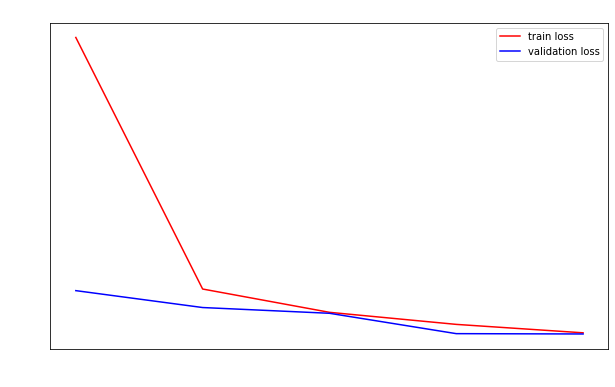

In [12]:
x = range(len(epoch_train_loss))
plt.rcParams["figure.figsize"] = (10, 6)
plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.', color='w')
plt.tick_params(axis='x', colors='w')
plt.tick_params(axis='y', colors='w')
plt.ylabel('loss', color='w')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', color='w')
plt.show()

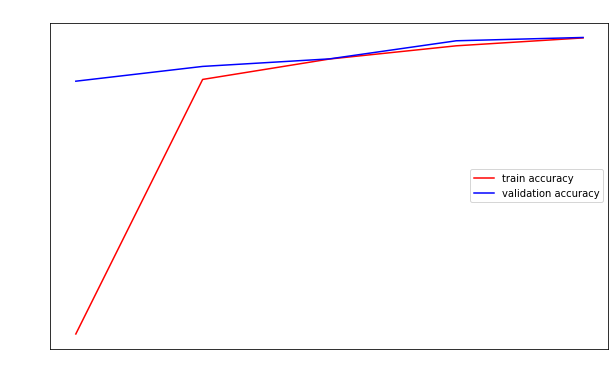

In [13]:
x = range(len(epoch_train_loss))
plt.rcParams["figure.figsize"] = (10, 6)
plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.', color='w')
plt.ylabel('accuracy', color='w')
plt.tick_params(axis='x', colors='w')
plt.tick_params(axis='y', colors='w')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy', color='w')
plt.show()

In [14]:
models = 'models'
if not os.path.exists(models):
    os.makedirs(models)
    
model_file_name = 'lenet5_mnist.pt'
model_path = os.path.join(models, model_file_name)
model.to('cpu')

torch.save(model.state_dict(), model_path)

In [15]:
lenet5_mnist = LeNet5()
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
def prediction(model, train_config, batch_input):
    """Predict data class"""
    model.to(train_config.device) # model to cpu/cuda 
    model.eval() # do model.eval() before prediction

    data = batch_input.to(train_config.device)
    output = model(data)

    prob = F.softmax(output, dim=1) # score to probability using softmax
    pred_prob = prob.data.max(dim=1)[0] # max probability
    pred_index = prob.data.max(dim=1)[1] # index of the max probability
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

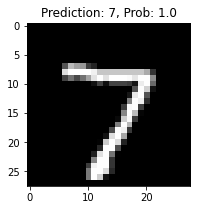

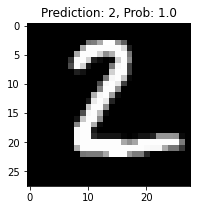

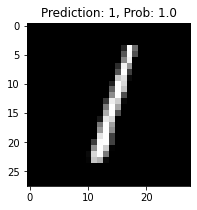

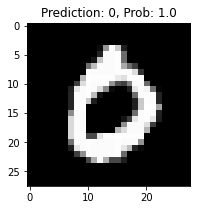

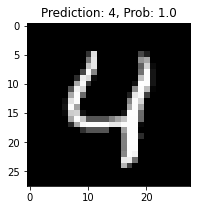

In [17]:
batch_size = 5
train_config = TrainingConfiguration()

# load test data w/out image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(
        root=train_config.data_root, 
        train=False, 
        download=True, 
        transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

# load testdata w/ image transformation
image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(
        root=train_config.data_root, 
        train=False, 
        download=True, 
        transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break
    
plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break